# RefBool

In [1]:
import sys
sys.path.insert(0, "/root/host_home/pylibs")
print(sys.path)


['/root/host_home/pylibs', '/root/host_home/notebooks/jenie-notebooks', '/opt/python/lib/python38.zip', '/opt/python/lib/python3.8', '/opt/python/lib/python3.8/lib-dynload', '', '/opt/python/lib/python3.8/site-packages', '/opt/python/lib/python3.8/site-packages/IPython/extensions', '/root/.ipython']


In [18]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pybedtools as pbt
from tqdm.notebook import tqdm
import os

import jenie.distributions as jdist
import jenie.multiproc as jmp


In [4]:
the_cache = {}

In [19]:
import importlib
def reload_user_libs():
    importlib.reload(jdist)
    importlib.reload(jmp)
    print("Reloaded")

Reloaded


0it [00:00, ?it/s]

Range: (0.0, 251.125153335268), Mean: 11.784157962912127, Median: 1.59870681537522
Off: 254@0.25466637211917365, On: 139@18.519067338216477


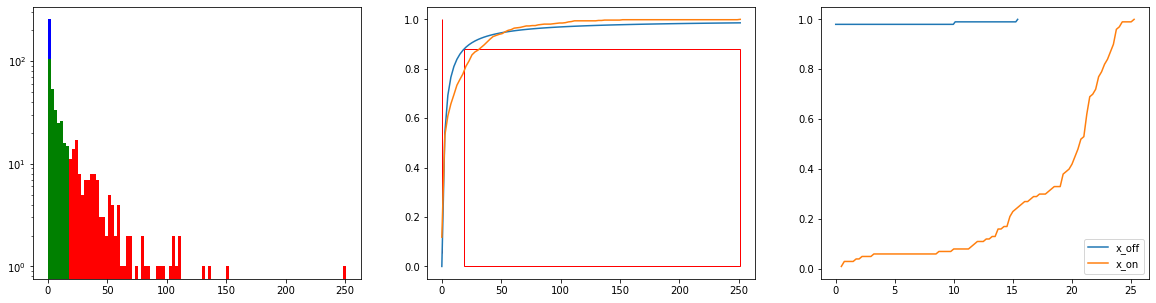

In [22]:
reload_user_libs()

class RefBool():
    def __init__(self):
        self.base_folder = "/root/host_home/external/irene"
    def load_ref_data(self):
        if not ('ref_data' in the_cache):
            ref_folder = os.path.join(self.base_folder, "data/RefBool_ReferenceDistributions/reference")
            ref_data = pd.read_csv(os.path.join(ref_folder, "ExpressionLibrary.txt"), sep = '\t')
            ref_data.rename(columns = {'geneID': 'gene_id'}, inplace = True)
            ref_data.set_index('gene_id', inplace = True)
            print("Ref Expr Data: ", ref_data.shape)
            gene_mapping = pd.read_csv(os.path.join(ref_folder, "Co_TF_CRF_Biomart.txt"), sep = '\t')
            gene_mapping.set_index('gene_id', inplace = True)
            print("Gene Mapping: ", gene_mapping.shape)
            ref_data = gene_mapping.join(ref_data,  how='inner')
            ref_data.reset_index(drop = True, inplace = True)
            ref_data.set_index('gene_name', inplace = True)
            display(ref_data)
            #ref_data.drop(columns = ['geneID', 'gene_id'])
            the_cache['ref_data'] = ref_data
            
        self.ref_data = the_cache['ref_data']
        self.n_genes = self.ref_data.shape[0]
        self.n_samples = self.ref_data.shape[1]
    
    def determine_threshold_distribution(self, bootstrap_samples = 1000, precision = 1e-3, sortby = 'AIC', takeMaxThresholds = False):
        self.all_fit_dist(self.ref_data, sortby)
    
    def all_fit_dist(self, data, sortby):
        #   sorted by the parameter SORTBY
        # NLogL - Negative of the log likelihood
        # BIC - Bayesian information criterion (default)
        # AIC - Akaike information criterion
        # AICc - AIC with a correction for finite sample sizes        

        self.distributions = {}
        #selected_genes = ['NANOG']
        # ['SNAI1', 'SNAI2', 'ZEB1', 'TWIST1', 'TWIST2', 'LEF1', 'ETS1', 'FOXC2', 'GSC', 'GSC2']
        selected_genes = ['SNAI2']
        #total_genes = len(selected_genes)
        #genes = np.random.randint(0, self.n_genes, total_genes)
        gene_data = [{"raw_data" : data.loc[gene_name]} for gene_name in selected_genes]
        
        def on_success(x):
            self.distributions[x["index"]] = x["value"]
            
        runner = jmp.MPRunner(
          func = jdist.fit_distribution,
          success_cb = on_success
        )
        runner.apply(gene_data)
        
    def plot_ecdf(self, ax, data, plt_args = None):
        from statsmodels.distributions.empirical_distribution import ECDF
        data_min = np.min(data)
        data_max = np.max(data)
        x = np.linspace(data_min, data_max, 100)
        ecdf = ECDF(data)
        if plt_args is None:
            plt_args = {}
        ax.plot(x, ecdf(x), **plt_args)
        
    def plot1(self):
        import matplotlib.patches as patches
        import scipy.interpolate as interp
        
        fig, ax = plt.subplots(1, 3, figsize = (20, 5))

        dist1 = self.distributions[0]
        raw = dist1["raw"]
        x_global = dist1["distrib"]["x"]
        #pdf = interp.interp1d(dist1["distrib"]["x"], dist1["distrib"]["pdf"])
        cdf = interp.interp1d(dist1["distrib"]["x"], dist1["distrib"]["cdf"])
        x_on_mean = dist1["x_on"].mean()
        x_off_mean = dist1["x_off"].mean()
        data_min = np.min(raw)
        data_max = np.max(raw)
        x_bins = np.linspace(data_min, data_max, 100)
        ind_off = dist1["raw"] < x_off_mean
        ind_on = dist1["raw"] > x_on_mean
        print(f"Range: ({data_min}, {data_max}), Mean: {np.mean(raw)}, Median: {np.median(raw)}")
        print(f"Off: {ind_off.sum()}@{x_off_mean}, On: {ind_on.sum()}@{x_on_mean}")
        #ax[0].hist(dist1["raw"], bins = x_bins, log = True, color = "blue")
        ax[0].hist(dist1["raw"][ind_off], bins = x_bins, log = True, color = "blue")
        ax[0].hist(dist1["raw"][~(ind_on | ind_off)], bins = x_bins, log = True, color = "green")
        ax[0].hist(dist1["raw"][ind_on], bins = x_bins, log = True, color = "red")
        
        ax[1].plot(x_global, dist1["distrib"]["cdf"])
        self.plot_ecdf(ax[1], raw)
        #ax[1].plot(x_global, ecdf(x_global))
        rect_off = patches.Rectangle((0, cdf(x_off_mean)), x_off_mean, 1 - cdf(x_off_mean), linewidth=1, edgecolor='r', facecolor='none')
        rect_on = patches.Rectangle((x_on_mean, 0), np.max(raw) - x_on_mean, cdf(x_on_mean), linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect_off)
        ax[1].add_patch(rect_on)
        
        self.plot_ecdf(ax[2], dist1["x_off"], {"label": "x_off"})
        self.plot_ecdf(ax[2], dist1["x_on"], {"label": "x_on"})
        ax[2].legend()
       
    def print(self):
        pass
        
rb = RefBool()
rb.load_ref_data()
rb.determine_threshold_distribution()
rb.plot1()
#rb.print()

In [70]:
rb.distributions

{16330: {'distr': <scipy.stats._continuous_distns.beta_gen at 0x7fdbcf2cd460>,
  'stats': 'RSS',
  'params': (2.7830258028532917,
   106104813581.60501,
   29.827244092660727,
   3072593952020.769),
  'name': 'beta',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fdc0afec040>,
  'score': 8.760647489822896e-06,
  'loc': 29.827244092660727,
  'scale': 3072593952020.769,
  'arg': (2.7830258028532917, 106104813581.60501),
  'CII_min_alpha': 50.34378743884005,
  'CII_max_alpha': 202.67670113751845},
 9014: {'distr': <scipy.stats._continuous_distns.expon_gen at 0x7fdbcf2ee4c0>,
  'stats': 'RSS',
  'params': (0.0, 0.10428468391290448),
  'name': 'expon',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fdbc2f87310>,
  'score': 3.8494966858709945,
  'loc': 0.0,
  'scale': 0.10428468391290448,
  'arg': (),
  'CII_min_alpha': 0.005349104992057265,
  'CII_max_alpha': 0.31240899323526455},
 23734: {'distr': <scipy.stats._continuous_distns.expon_gen at 0x7fdbcf2ee4c0>,
 

In [66]:
np.sort(np.array(rb.ref_data.loc[(rb.ref_data.duplicated(subset = ['gene_name'])), "gene_name"]))
np.array(rb.ref_data.filter(like="NANOG", axis = 0)

array(['ATF6B', 'ATF6B', 'ATF6B', 'BRD2', 'BRD2', 'BRD2', 'BRD2', 'BRD2',
       'BRD2', 'DAXX', 'DAXX', 'DAXX', 'DAXX', 'EHMT2', 'EHMT2', 'EHMT2',
       'EHMT2', 'EHMT2', 'EHMT2', 'GATAD2B', 'PAXBP1', 'PBX2', 'PBX2',
       'PBX2', 'PBX2', 'PBX2', 'PBX2', 'PHF1', 'POU5F1', 'POU5F1',
       'POU5F1', 'POU5F1', 'POU5F1', 'POU5F1', 'RING1', 'RING1', 'RING1',
       'RING1', 'RING1', 'RXRB', 'RXRB', 'RXRB', 'RXRB', 'RXRB', 'SALL3',
       'TCF19', 'TCF19', 'TCF19', 'TCF19', 'TCF19', 'TCF19', 'TCF20',
       'TRIM27', 'TRIM27', 'TRIM27', 'TRIM27', 'TRIM27', 'TRIM27',
       'ZBTB12', 'ZBTB12', 'ZBTB12', 'ZBTB12', 'ZFP57', 'ZFP57', 'ZFP57',
       'ZFP57', 'ZFP57', 'ZFP57', 'ZFP57', 'ZNF311', 'ZNF311', 'ZNF311',
       'ZNF311', 'ZNF311', 'ZNF311'], dtype=object)

In [38]:
rb.ref_data.loc['SNAI1']

Sample.290    4.311300
Sample.289    0.014694
Sample.295    9.642530
Sample.297    0.946624
Sample.293    0.981863
                ...   
Sample.243    7.630734
Sample.244    2.441336
Sample.245    1.445353
Sample.246    0.809330
Sample.247    8.472192
Name: SNAI1, Length: 675, dtype: float64

In [39]:
from scipy import stats
stats.describe(np.array(rb.ref_data.loc['SNAI1']).flatten())

DescribeResult(nobs=675, minmax=(0.0, 43.8984961943041), mean=3.5939809110131393, variance=24.6584761154946, skewness=3.170462665041427, kurtosis=14.215863471269)

In [1]:
import os
os.getcwd()

'/root/host_home/notebooks/jenie-notebooks'